In [1]:

import h5py
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from enum import Enum
import collections
import pyfftw
from pylab import meshgrid
from scipy.ndimage import gaussian_filter1d as gf
from scipy.signal import savgol_filter as sf
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
import pandas as pd
from scipy import interpolate
from matplotlib.lines import Line2D

%matplotlib inline
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']


fld = 'PATH_TO_PICTURES/'

class FIELD(Enum):
        __order__ = 'ELECTRIC MAGNETIC PRESDIAG PRESOFFD VELOCION CURRENTJ DENSITYI'
        ELECTRIC = [0,['Ex', 'Ey', 'Ez']]
        MAGNETIC = [1,['Bx', 'By', 'Bz']]
        PRESDIAG = [2,['Pxx[0]','Pyy[0]','Pzz[0]']]
        PRESOFFD = [3,['Pxy[0]','Pxz[0]','Pyz[0]']]
        VELOCION = [4,['Vix','Viy','Viz']]
        VELOCIEL = [5,['Vx[0]','Vy[0]','Vz[0]']]
        VELOCIPR = [6,['Vx[1]','Vy[1]','Vz[1]']]
        CURRENTJ = [8,['Jx','Jy','Jz']]
        DENSITYI = [9,['n[0]','n[1]']]
        
def loadData(times2Load, filePath):
            fileName = 'fields.h5'            
            f = h5py.File(filePath+fileName)
            domainSize = f.attrs["domainSize"]
            groups = f.keys()
            times = len([gr for gr in groups if gr.count('time') > 0])
   
            boxSizes = f.attrs["nbrOfCells"]
            allTimes = dict()
            idx=0
            for time2Load in times2Load:
                    allData = collections.defaultdict(lambda: np.ndarray(0))
                    grNm =  'time : {0:.6f}'.format(time2Load)
                    if grNm not in groups:
                        print 'no group name [', grNm, '] in fields.h5'
                        print 'snapshots number = ', times, '; number of keys = ', len(groups)
                        grNm =  groups[(len(groups) - 1)]                        
                        print 'time2Load  = ', time2Load, '; used group name = ', grNm
                    for fld in FIELD:
                        data = np.zeros([boxSizes[0]+1, boxSizes[1]+1, 3]) 
                        idx = 0
                        for field in fld.value[1]:
                                        data[...,idx] = f[grNm+'/'+field].value[...,0]
                                        idx += 1
                        allData[fld] = data  
                    allTimes[time2Load] = allData                    
            f.close()
            return [allTimes, domainSize]

class FTR(Enum):
        __order__ = 'B_0 B_1 A_Z'
        B_0 = ['bxo', 'byo']
        B_1 = ['bx1', 'by1']
        A_Z = ['azo', 'az1']
        
def fourierFlux(bfield, domsize) :
            dim = [bfield.shape[0], bfield.shape[1]]
            d = dict()
            for f in FTR:
                d[f.value[0]] = pyfftw.empty_aligned(dim, dtype = 'complex128')
                d[f.value[1]] = pyfftw.empty_aligned(dim, dtype = 'complex128')
            
            for axis in range(2):
                fftXY = pyfftw.FFTW(d[FTR.B_0.value[axis]], d[FTR.B_1.value[axis]], axes=(0, 1), 
                                  direction='FFTW_FORWARD', flags=('FFTW_MEASURE', ))                
                d[FTR.B_0.value[axis]].real[...] = bfield[..., axis]
                d[FTR.B_0.value[axis]].imag = np.zeros(dim, dtype = float)
                fftXY.update_arrays(d[FTR.B_0.value[axis]], d[FTR.B_1.value[axis]])
                pyfftw.FFTW.execute(fftXY)
            
            wy, wx = meshgrid(np.fft.fftfreq(dim[1], 1.0/dim[1])/domsize[1], 
                              np.fft.fftfreq(dim[0], 1.0/dim[0])/domsize[0])
            k2 = np.square(2*np.pi*wx)+np.square(2*np.pi*wy)
            k2[0][0] = 1.0
            
            fftBack = pyfftw.FFTW(d[FTR.A_Z.value[0]], d[FTR.A_Z.value[1]], axes=(0, 1), 
                                  direction='FFTW_BACKWARD', flags=('FFTW_MEASURE',))            
            d[FTR.A_Z.value[1]] = np.divide(1j*(wx*d[FTR.B_1.value[1]]-wy*d[FTR.B_1.value[0]]), k2)
            d[FTR.A_Z.value[1]][0][0] = 0.0
            fftBack.update_arrays(d[FTR.A_Z.value[1]], d[FTR.A_Z.value[0]])
            pyfftw.FFTW.execute(fftBack)
            return d[FTR.A_Z.value[0]].real
        
        
def GetXPoint(flux):
    if (flux[1,4] > flux[1,3]):
        flux_max_i   = flux.max(axis=1)
        flux_max_pos = flux.argmax(axis=1)
        flux_min_pos = flux_max_i.argmin()
        return (flux_min_pos, flux_max_pos[flux_min_pos])
    else:
        flux_min_i   = flux.min(axis=1)
        flux_min_pos = flux.argmin(axis=1)
        flux_max_pos = flux_min_i.argmax()
        return (flux_max_pos, flux_min_pos[flux_max_pos])


deltaX = 0.1
deltaY = 0.1
deltaZ = 0.1
    
def dx(var):
    return gf(var, order=1,sigma=1, axis=0)/deltaX

def dy(var):
    return gf(var, order=1,sigma=1, axis=1)/deltaY

def dz(var):
    return gf(var, order=1,sigma=1, axis=2)/deltaZ


def GetAvgDriver_ii(fldr, times):
    deltaX = 0.1
    deltaY = deltaX
    [data, domainSize] = loadData(times, fldr)
    NUM = len(times)
    DRIVER_COMP = [0,0,0]
    DRIVER_ADV  = [0,0,0]
    DRIVER_SYM  = [[0,0],[0,0],[0,0]]
    for time in times:        
        J  = data[time][FIELD.CURRENTJ]
        Vi = data[time][FIELD.VELOCION]
        n  = data[time][FIELD.DENSITYI][...,0]
        Ve = np.zeros(Vi.shape)
        Ve[...,0] = Vi[...,0] - J[...,0]/n
        Ve[...,1] = Vi[...,1] - J[...,1]/n
        Ve[...,2] = Vi[...,2] - J[...,2]/n
        
        presdiag = data[time][FIELD.PRESDIAG]
        presoffd = data[time][FIELD.PRESOFFD]
        Pxx = presdiag[...,0]
        Pyy = presdiag[...,1]
        Pzz = presdiag[...,2]
        Pxy = presoffd[...,0]
        Pxz = presoffd[...,1]
        Pyz = presoffd[...,2]
        
        vxdx = dx(Ve[...,0])
        vxdy = dy(Ve[...,0])
        vydx = dx(Ve[...,1])
        vydy = dy(Ve[...,1])
        vzdx = dx(Ve[...,2])
        vzdy = dy(Ve[...,2])
        
        divV = vxdx+vydy
        
        Pxxdx = dx(Pxx)
        Pxxdy = dy(Pxx)
        Pyydx = dx(Pyy)
        Pyydy = dy(Pyy)
        Pzzdx = dx(Pzz)
        Pzzdy = dy(Pzz)
        
        DRIVER_COMP[0] += -Pxx*divV
        DRIVER_COMP[1] += -Pyy*divV
        DRIVER_COMP[2] += -Pzz*divV
        
        DRIVER_ADV[0] += -Ve[...,0]*Pxxdx - Ve[...,1]*Pxxdy
        DRIVER_ADV[1] += -Ve[...,0]*Pyydx - Ve[...,1]*Pyydy
        DRIVER_ADV[2] += -Ve[...,0]*Pzzdx - Ve[...,1]*Pzzdy
        
        DRIVER_SYM[0][0] += -2.0*Pxx*vxdx
        DRIVER_SYM[0][1] += -2.0*Pxy*vxdy
        
        DRIVER_SYM[1][0] += -2.0*Pxy*vydx
        DRIVER_SYM[1][1] += -2.0*Pyy*vydy
        
        DRIVER_SYM[2][0] += -2.0*Pxz*vzdx
        DRIVER_SYM[2][1] += -2.0*Pyz*vzdy
        
    for k in range(3):
        DRIVER_COMP[k] /= NUM
        DRIVER_ADV[k] /= NUM
        DRIVER_SYM[k][0] /= NUM
        DRIVER_SYM[k][1] /= NUM
        
    return [DRIVER_COMP, DRIVER_ADV, DRIVER_SYM]


def GetAvgCyclotron_ii(fldr, times):
    [data, domainSize] = loadData(times, fldr)
    NUM = len(times)
    CYCLOTRON_DIAG  = [[0,0],[0,0],[0,0]]
    for time in times:
        B  = data[time][FIELD.MAGNETIC]        
        me = 0.01
        Btot = np.sqrt(B[...,0]*B[...,0] + B[...,1]*B[...,1] + B[...,2]*B[...,2])
        cyclFreq = Btot/me
        Bunit = [B[...,0]/Btot, B[...,1]/Btot, B[...,2]/Btot]
        presoffd = data[time][FIELD.PRESOFFD]
        Pxy = presoffd[...,0]
        Pxz = presoffd[...,1]
        Pyz = presoffd[...,2]        
        
        CYCLOTRON_DIAG[0][0] += -2.0*Pxy*Bunit[2]*cyclFreq
        CYCLOTRON_DIAG[0][1] +=  2.0*Pxz*Bunit[1]*cyclFreq
        
        CYCLOTRON_DIAG[1][0] += -2.0*Pyz*Bunit[0]*cyclFreq
        CYCLOTRON_DIAG[1][1] +=  2.0*Pxy*Bunit[2]*cyclFreq
        
        CYCLOTRON_DIAG[2][0] += -2.0*Pxz*Bunit[1]*cyclFreq
        CYCLOTRON_DIAG[2][1] +=  2.0*Pyz*Bunit[0]*cyclFreq
        
        
    for k in range(3):
        CYCLOTRON_DIAG[k][0] /= NUM
        CYCLOTRON_DIAG[k][1] /= NUM
        
    return CYCLOTRON_DIAG

def GetAvgIzotropization_ii(fldr, times):
    [data, domainSize] = loadData(times, fldr)
    NUM = len(times)    
    tau = 1
    ISOTROPIZATION = [0,0,0]
    for time in times:
        presdiag = data[time][FIELD.PRESDIAG]
        Pxx = presdiag[...,0]
        Pyy = presdiag[...,1]
        Pzz = presdiag[...,2]
        trace = Pxx+Pyy+Pzz
        ISOTROPIZATION[0] += -(Pxx - trace/3)*tau
        ISOTROPIZATION[1] += -(Pyy - trace/3)*tau
        ISOTROPIZATION[2] += -(Pzz - trace/3)*tau
    for k in range(3):
        ISOTROPIZATION[k] /= NUM   
    return ISOTROPIZATION


def GetAvgDriver_ij(fldr, times):
    deltaX = 0.1
    deltaY = deltaX
    [data, domainSize] = loadData(times, fldr)
    NUM = len(times)
    DRIVER_COMP = [0,0,0]
    DRIVER_ADV  = [0,0,0]
    DRIVER_SYM  = [[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    for time in times:        
        J  = data[time][FIELD.CURRENTJ]
        Vi = data[time][FIELD.VELOCION]
        n  = data[time][FIELD.DENSITYI][...,0]
        Ve = np.zeros(Vi.shape)
        Ve[...,0] = Vi[...,0] - J[...,0]/n
        Ve[...,1] = Vi[...,1] - J[...,1]/n
        Ve[...,2] = Vi[...,2] - J[...,2]/n
        
        presdiag = data[time][FIELD.PRESDIAG]
        presoffd = data[time][FIELD.PRESOFFD]
        Pxx = presdiag[...,0]
        Pyy = presdiag[...,1]
        Pzz = presdiag[...,2]
        Pxy = presoffd[...,0]
        Pxz = presoffd[...,1]
        Pyz = presoffd[...,2]
        
        vxdx = dx(Ve[...,0])
        vxdy = dy(Ve[...,0])
        vydx = dx(Ve[...,1])
        vydy = dy(Ve[...,1])
        vzdx = dx(Ve[...,2])
        vzdy = dy(Ve[...,2])
        
        divV = vxdx+vydy
        
        Pxydx = dx(Pxy)
        Pxydy = dy(Pxy)
        Pxzdx = dx(Pxz)
        Pxzdy = dy(Pxz)
        Pyzdx = dx(Pyz)
        Pyzdy = dy(Pyz)
        
        DRIVER_COMP[0] += -Pxy*divV
        DRIVER_COMP[1] += -Pxz*divV
        DRIVER_COMP[2] += -Pyz*divV
        
        DRIVER_ADV[0] += -Ve[...,0]*Pxydx - Ve[...,1]*Pxydy
        DRIVER_ADV[1] += -Ve[...,0]*Pxzdx - Ve[...,1]*Pxzdy
        DRIVER_ADV[2] += -Ve[...,0]*Pyzdx - Ve[...,1]*Pyzdy        
        
        DRIVER_SYM[0][0] += -Pxx*vydx
        DRIVER_SYM[0][1] += -Pxy*vydy
        DRIVER_SYM[0][2] += -Pxy*vxdx
        DRIVER_SYM[0][3] += -Pyy*vxdy
        
        DRIVER_SYM[1][0] += -Pxx*vzdx
        DRIVER_SYM[1][1] += -Pxy*vzdy
        DRIVER_SYM[1][2] += -Pxz*vxdx
        DRIVER_SYM[1][3] += -Pyz*vxdy
        
        DRIVER_SYM[2][0] += -Pxy*vzdx
        DRIVER_SYM[2][1] += -Pyy*vzdy
        DRIVER_SYM[2][2] += -Pxz*vydx
        DRIVER_SYM[2][3] += -Pyz*vydy
        
    for k in range(3):
        DRIVER_COMP[k] /= NUM
        DRIVER_ADV[k] /= NUM
        for l in range(4):
            DRIVER_SYM[k][l] /= NUM
        
    return [DRIVER_COMP, DRIVER_ADV, DRIVER_SYM]


def GetAvgCyclotron_ij(fldr, times):
    [data, domainSize] = loadData(times, fldr)
    NUM = len(times)
    CYCLOTRON_OFFD  = [[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    for time in times:
        B  = data[time][FIELD.MAGNETIC]        
        me = 0.01
        Btot = np.sqrt(B[...,0]*B[...,0] + B[...,1]*B[...,1] + B[...,2]*B[...,2])
        cyclFreq = Btot/me
        Bunit = [B[...,0]/Btot, B[...,1]/Btot, B[...,2]/Btot]
        presdiag = data[time][FIELD.PRESDIAG]
        presoffd = data[time][FIELD.PRESOFFD]
        Pxx = presdiag[...,0]
        Pyy = presdiag[...,1]
        Pzz = presdiag[...,2]
        Pxy = presoffd[...,0]
        Pxz = presoffd[...,1]
        Pyz = presoffd[...,2]
        
        CYCLOTRON_OFFD[0][0] += -Pxz*Bunit[0]*cyclFreq
        CYCLOTRON_OFFD[0][1] +=  Pxx*Bunit[2]*cyclFreq
        CYCLOTRON_OFFD[0][2] += -Pyy*Bunit[2]*cyclFreq
        CYCLOTRON_OFFD[0][3] +=  Pyz*Bunit[1]*cyclFreq
        
        CYCLOTRON_OFFD[1][0] += -Pxx*Bunit[1]*cyclFreq
        CYCLOTRON_OFFD[1][1] +=  Pxy*Bunit[0]*cyclFreq
        CYCLOTRON_OFFD[1][2] += -Pyz*Bunit[2]*cyclFreq
        CYCLOTRON_OFFD[1][3] +=  Pzz*Bunit[1]*cyclFreq
        
        CYCLOTRON_OFFD[2][0] += -Pxy*Bunit[1]*cyclFreq
        CYCLOTRON_OFFD[2][1] +=  Pyy*Bunit[0]*cyclFreq
        CYCLOTRON_OFFD[2][2] += -Pzz*Bunit[0]*cyclFreq
        CYCLOTRON_OFFD[2][3] +=  Pxz*Bunit[2]*cyclFreq
        
        
    for k in range(3):
        for l in range(4):
            CYCLOTRON_OFFD[k][l] /= NUM
        
    return CYCLOTRON_OFFD

def GetAvgIzotropization_ij(fldr, times):
    [data, domainSize] = loadData(times, fldr)
    NUM = len(times)    
    tau = 1
    ISOTROPIZATION = [0,0,0]
    for time in times:       
        presoffd = data[time][FIELD.PRESOFFD]
        Pxy = presoffd[...,0]
        Pxz = presoffd[...,1]
        Pyz = presoffd[...,2] 
        ISOTROPIZATION[0] += -Pxy*tau 
        ISOTROPIZATION[1] += -Pxz*tau
        ISOTROPIZATION[2] += -Pyz*tau 
    for k in range(3):
        ISOTROPIZATION[k] /= NUM   
    return ISOTROPIZATION


def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

max =  0.545792758465
max =  0.054008692503
max =  0.0775620937347
max =  0.0187534186989
max =  0.0163601059467
max =  0.00473968451843


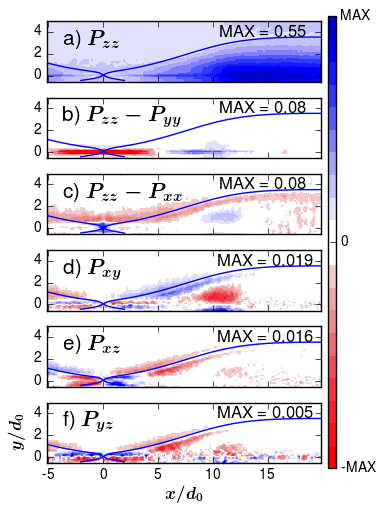

In [2]:
time = 80.0
direct = 'PATH_TO_RUN_B'
[data, domainSize] = loadData([time], direct)
B  = data[time][FIELD.MAGNETIC]
contourData = fourierFlux(B, domainSize)

presdiag = data[time][FIELD.PRESDIAG]
Pxx = presdiag[...,0]
Pyy = presdiag[...,1]
Pzz = presdiag[...,2]

presoffd = data[time][FIELD.PRESOFFD]
Pxy = presoffd[...,0]
Pxz = presoffd[...,1]
Pyz = presoffd[...,2]

fig, axes = plt.subplots(nrows=6, ncols=1, figsize = cm2inch(9, 15), dpi = 300)


diffmap_17 = ["#FF0000", "#F81318", "#F12731", "#EB3B4A", "#EB5C66", "#EB7D82", 
              "#EB9E9E", "#F1BEBE", "#FFFFFF", "#FFFFFF", "#DDDCFD", "#BCB9FB", 
              "#9B96FA", "#6A6CFA", "#3A43FA", "#1D21FC", "#0000FF", "#0000ce"]
cmap = LinearSegmentedColormap.from_list('diffmap_17', diffmap_17, N=20)


limits = [0,0,0,0]

major_ticks_x = np.arange(-5, 20, 5)
major_ticks_y = np.arange(0, 6, 2)

xp = GetXPoint(contourData)
limits[0] = xp[0]-50
limits[1] = xp[0]+200
limits[2] = xp[1]-5
limits[3] = limits[2]+55


LABEL_FONTSIZE = 12
TICKS_FONTSIZE = 10
TEXT_FONTSIZE = 12
NAME_TEXT_FONTSIZE = 15
LINE_WIDTH = 1


X_LENGTH = limits[1]-limits[0]
Y_LENGTH = limits[3]-limits[2]

LABL_X_COORD = 0
LABL_Y_COORD = 1.05*Y_LENGTH

LBL_SIZE = 20

        
LABELS = ['$P_{zz}$', '$P_{zz}-P_{yy}$', '$P_{zz}-P_{xx}$']
LABL = ['a)','b)','c)']
labelY = " $yc / \omega_{pi}$"
PL2 = [Pzz, Pzz-Pyy, Pzz-Pxx]
for i in range(3):
    toPlot = PL2[i]
    axFIG = axes[i]
    MAX = round(max([toPlot.max(), abs(toPlot.min())]),2)
    if i != 0:
        MAX = 0.08
    print 'max = ', toPlot.max()
    name = "MAX = "+str(MAX)
    img = axFIG.imshow(np.transpose(toPlot[limits[0]:limits[1],limits[2]:limits[3]]), 
                                interpolation = 'nearest',  origin='lower', 
                                aspect = 'equal', vmin=-MAX,vmax=MAX,   cmap=cmap)

    
    axFIG.text(X_LENGTH*0.63,2*Y_LENGTH*0.37,  name,color='black', weight='bold', bbox={'facecolor': 'none', 'pad': 1, 'edgecolor':'none'}, fontsize=TEXT_FONTSIZE)

    axFIG.set_xticklabels('')
    axFIG.set_yticklabels('')
    axFIG.set_xticks(np.arange(1, 251, 50))
    axFIG.set_yticks(np.arange(5, 55, 20))    
    

    axFIG.set_yticklabels(major_ticks_y, fontsize=TICKS_FONTSIZE)
    
    axFIG.text(14, Y_LENGTH*0.55, LABL[i]+" "+LABELS[i], color='black', bbox={'facecolor': 'none', 'pad': 5, 'edgecolor':'none'}, fontsize=NAME_TEXT_FONTSIZE)
    axFIG.contour(np.transpose(contourData[limits[0]:limits[1],limits[2]:limits[3]]),
                  levels = [contourData[xp[0],xp[1]]],
                               flines = None,colors = ('b',),origin = 'lower',
                                          linestyles = 'solid',linewidths = LINE_WIDTH)
    
    
LABELS = ['$P_{xy}$', '$P_{xz}$', '$P_{yz}$']

LABL = ['d)','e)','f)']
PL2 = [Pxy, Pxz, Pyz]
for i in range(3):
    
    toPlot = PL2[i]
    MAX = round(max([toPlot.max(), abs(toPlot.min())]),3)
    print 'max = ', toPlot.max()
    name = "MAX = "+str(MAX)
    axFIG = axes[i+3]
    img = axFIG.imshow(np.transpose(toPlot[limits[0]:limits[1],limits[2]:limits[3]]), 
                                interpolation = 'nearest',  origin='lower', 
                                aspect = 'equal', vmin=-MAX,vmax=MAX,   cmap=cmap)
    axFIG.text(X_LENGTH*0.62,2*Y_LENGTH*0.37, name,color='black', weight='bold', bbox={'facecolor': 'none', 'pad': 1, 'edgecolor':'none'}, fontsize=TEXT_FONTSIZE)
    
     
    axFIG.set_xticklabels('')
    axFIG.set_yticklabels('')
    axFIG.set_xticks(np.arange(1, 251, 50))
    axFIG.set_yticks(np.arange(5, 55, 20))
    if i == 2:    
            axFIG.set_xlabel(" $x / d_{0}$", fontsize=LABEL_FONTSIZE , weight='bold')  
            axFIG.set_ylabel(" $y / d_{0}$", fontsize=LABEL_FONTSIZE , weight='bold')
            axFIG.set_xticklabels(major_ticks_x, fontsize=TICKS_FONTSIZE)
            
    axFIG.set_yticklabels(major_ticks_y, fontsize=TICKS_FONTSIZE)
    
    axFIG.text(14, Y_LENGTH*0.55, LABL[i]+" "+LABELS[i], color='black', bbox={'facecolor': 'none', 'pad': 5, 'edgecolor':'none'}, fontsize=NAME_TEXT_FONTSIZE)
    axFIG.contour(np.transpose(contourData[limits[0]:limits[1],limits[2]:limits[3]]),
                  levels = [contourData[xp[0],xp[1]]],
                               flines = None,colors = ('b',),origin = 'lower',
                                          linestyles = 'solid',linewidths = LINE_WIDTH)    

            
cbaxes = fig.add_axes([0.92, 0.13, 0.02, 0.765])
cb = plt.colorbar(img, cax = cbaxes, ticks=[-MAX, 0.0, MAX])
cb.ax.set_yticklabels(['-MAX', '0', 'MAX'])
cb.ax.tick_params(labelsize=TICKS_FONTSIZE)
cbaxes.yaxis.set_ticks_position('right')

# 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)


filenew = fld+'diag_offd_runB.eps'
plt.savefig(filenew,dpi = 500, bbox_inches = "tight", format='eps') 

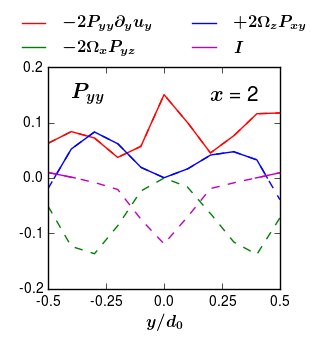

In [3]:
def plotWithMask(axes, label, operator, mask, color, lw):
    axes.plot(operator[mask].fillna(operator), ls = '--', color=color, lw=lw)
    axes.plot(operator[mask],label=label, ls='-', color=color, lw=lw)
    

def plotCrossSectionAlongY(DATAS2PLOT, baseMask, xp, LBL, TXT, Y_LIM, major_ticks_y):
    
    limits = [0,0,0,0]
    limits[2] = xp[1]-5
    limits[3] = xp[1]+6
    xCross  = xp[0]+20
    repeats_times = 1000
    Y_EXT = limits[3]-limits[2]
    Y_EXT_arr = np.arange(0, Y_EXT)
    Y_EXT_PLUS_arr = np.arange(0, Y_EXT-1, 0.01)
    X_LIM = repeats_times
    
    f = interpolate.interp1d(Y_EXT_arr, baseMask[xCross,limits[2]:limits[3]])
    baseMask = pd.DataFrame(f(Y_EXT_PLUS_arr))

    major_ticks_x = np.arange(-0.5, 0.51, 0.25)

    fig, axB = plt.subplots(nrows=1, ncols=1, figsize = cm2inch(9, 9), dpi = 300)
    
    LABEL_FONTSIZE = 12
    TICKS_FONTSIZE = 10
    TEXT_FONTSIZE = 12
    NAME_TEXT_FONTSIZE = 15    
    LINE_WIDTH = 1
    
    CLR = ['r', 'g', 'b', 'm']
    for k in range(len(DATAS2PLOT)):
        f = interpolate.interp1d(Y_EXT_arr, DATAS2PLOT[k][xCross, limits[2]:limits[3]])
        operator=pd.DataFrame(f(Y_EXT_PLUS_arr))
        mask = baseMask*operator >= 0.0
        plotWithMask(axes=axB, label=LBL[k], operator=operator, mask = mask, color=CLR[k], lw=LINE_WIDTH) 

    Y_POS = Y_LIM[1]*0.7
    axB.text(X_LIM*0.1, Y_POS, TXT[0], color='black', bbox={'facecolor': 'none', 'pad': 5, 'edgecolor':'none'}, fontsize=NAME_TEXT_FONTSIZE)
    axB.text(X_LIM*0.70, Y_POS, TXT[1], color='black', bbox={'facecolor': 'none', 'pad': 5, 'edgecolor':'none'}, fontsize=NAME_TEXT_FONTSIZE)
    
    axB.set_xticks(np.arange(0, X_LIM+1, X_LIM/4))
    axB.set_xticklabels(major_ticks_x, fontsize=TICKS_FONTSIZE)
    axB.tick_params(axis='x', which='major', pad=5)
    axB.set_xlabel('$y / d_{0}$', fontsize=LABEL_FONTSIZE)
    axB.set_yticks(major_ticks_y)
    axB.set_yticklabels(major_ticks_y, fontsize=TICKS_FONTSIZE)
    axB.set_ylim(Y_LIM)
    
    fig.tight_layout(pad=3.0)
    
    return axB



direct = 'PATH_TO_RUN_B' # iso 

t =80.0
AVG_TIME = 0.1
times_avg = np.arange(t-AVG_TIME,t+AVG_TIME+0.1,0.1)
[DRIVER_COMP, DRIVER_ADV, DRIVER_SYM] = GetAvgDriver_ii(direct, times_avg)
CYCLOTRON_D = GetAvgCyclotron_ii(direct, times_avg)
IZO = GetAvgIzotropization_ii(direct, times_avg)
[data, domainSize] = loadData([t], direct)
B  = data[t][FIELD.MAGNETIC]
contourData = fourierFlux(B, domainSize)
xp = GetXPoint(contourData)

presdiag = data[t][FIELD.PRESDIAG]
i = 1 # Pyy
DATAS2PLOT = [DRIVER_SYM[i][1], CYCLOTRON_D[i][0], CYCLOTRON_D[i][1], IZO[i]]
LBL = ['$-2P_{yy}\partial_y u_y$', '$-2\Omega_xP_{yz}$','$+2\Omega_zP_{xy}$', '$I$']


baseMask = presdiag[...,1]

Y_LIM=[-0.2,0.2]
major_ticks_y = np.arange(-0.2, 0.21, 0.1)
axB  = plotCrossSectionAlongY(DATAS2PLOT, baseMask, xp, LBL, ['$P_{yy}$', '$x$ = 2'], Y_LIM, major_ticks_y)
LEGEND_FONTSIZE = 12
axB.legend(loc="upper left", bbox_to_anchor=[-0.2,1.3],
           ncol=2, shadow=False, fancybox=True, framealpha=0.0, fontsize=LEGEND_FONTSIZE)
    
    
filenew = fld+'pyy.eps'
plt.savefig(filenew,dpi = 500, bbox_inches = "tight",format="eps") 

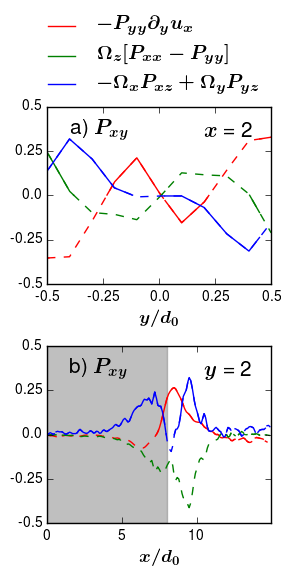

In [5]:
def plotCrossSectionAlongYandAlongX(DATAS2PLOT, baseMask, xp, LBL, TXT, Y_LIM, major_ticks_y):
    
    limits = [0,0,0,0]
    limits[2] = xp[1]-5
    limits[3] = xp[1]+6
    xCross  = xp[0]+20
    repeats_times = 1000
    Y_EXT = limits[3]-limits[2]
    Y_EXT_arr = np.arange(0, Y_EXT)
    Y_EXT_PLUS_arr = np.arange(0, Y_EXT-1, 0.01)
    X_LIM = repeats_times
    
    f = interpolate.interp1d(Y_EXT_arr, baseMask[xCross,limits[2]:limits[3]])
    baseMask0 = pd.DataFrame(f(Y_EXT_PLUS_arr))

    major_ticks_x = np.arange(-0.5, 0.51, 0.25)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize = cm2inch(9, 14), dpi = 300)
    
    LABEL_FONTSIZE = 13
    TICKS_FONTSIZE = 10
    TEXT_FONTSIZE = 12
    NAME_TEXT_FONTSIZE = 15    
    LINE_WIDTH = 1    
    
    axA = axes[0]
    axB = axes[1]
    
    CLR = ['r', 'g', 'b', 'm']
    for k in range(len(DATAS2PLOT)):
        f = interpolate.interp1d(Y_EXT_arr, DATAS2PLOT[k][xCross, limits[2]:limits[3]])
        operator=pd.DataFrame(f(Y_EXT_PLUS_arr))
        mask = baseMask0*operator >= 0.0
        plotWithMask(axes=axA, label=LBL[k], operator=operator, mask = mask, color=CLR[k], lw=LINE_WIDTH) 

    Y_POS = Y_LIM[1]*0.66
    axA.text(X_LIM*0.1, Y_POS, 'a) '+TXT[0], color='black', bbox={'facecolor': 'none', 'pad': 5, 'edgecolor':'none'}, fontsize=NAME_TEXT_FONTSIZE)
    axA.text(X_LIM*0.70, Y_POS, '$x$ = '+TXT[1], color='black', bbox={'facecolor': 'none', 'pad': 5, 'edgecolor':'none'}, fontsize=NAME_TEXT_FONTSIZE)
    
    axA.set_xticks(np.arange(0, X_LIM+1, X_LIM/4))
    axA.set_xticklabels(major_ticks_x, fontsize=TICKS_FONTSIZE)
    axA.tick_params(axis='x', which='major', pad=5)
    axA.set_xlabel('$y / d_{0}$', fontsize=LABEL_FONTSIZE)
    axA.set_yticks(major_ticks_y)
    axA.set_yticklabels(major_ticks_y, fontsize=TICKS_FONTSIZE)
    axA.set_ylim(Y_LIM)
    
    limits = [0,0,0,0]
    limits[0] = xp[0]
    limits[1] = xp[0]+150

    yCross  = xp[1]+20
    repeats_times = 1000
    X_EXT = limits[1]-limits[0]
    X_EXT_arr = np.arange(0, X_EXT)
    X_EXT_PLUS_arr = np.arange(0, X_EXT-1, 0.01)

    X_LIM = X_EXT/0.01 
    
    f = interpolate.interp1d(X_EXT_arr, baseMask[limits[0]:limits[1],yCross])
    baseMask1 = pd.DataFrame(f(X_EXT_PLUS_arr))
    
    for k in range(len(DATAS2PLOT)):
        f = interpolate.interp1d(X_EXT_arr, DATAS2PLOT[k][limits[0]:limits[1],yCross])
        operator=pd.DataFrame(f(X_EXT_PLUS_arr))
        mask = baseMask1*operator >= 0.0
        plotWithMask(axes=axB, label=LBL[k], operator=operator, mask = mask, color=CLR[k], lw=LINE_WIDTH) 

    fig.tight_layout(pad=2.5)

    Y_POS = Y_LIM[1]*0.66
    axB.text(X_LIM*0.1, Y_POS, 'b) '+TXT[0], color='black', bbox={'facecolor': 'none', 'pad': 5, 'edgecolor':'none'}, fontsize=NAME_TEXT_FONTSIZE)
    axB.text(X_LIM*0.7, Y_POS, '$y$ = '+TXT[1], color='black', bbox={'facecolor': 'none', 'pad': 5, 'edgecolor':'none'}, fontsize=NAME_TEXT_FONTSIZE)

    major_ticks_x = np.arange(0., 15.0, 5) 
    axB.axvspan(0, 8000, alpha=0.5, color='grey')
    axB.set_xticks(np.arange(0, X_LIM+1, X_LIM/3))
    axB.set_xticklabels(major_ticks_x.astype(int), fontsize=TICKS_FONTSIZE)
    axB.set_yticks(major_ticks_y)
    axB.set_yticklabels(major_ticks_y, fontsize=TICKS_FONTSIZE)
    axB.tick_params(axis='x', which='major', pad=5)
    axB.set_xlabel('$x / d_{0}$', fontsize=LABEL_FONTSIZE)
    axB.set_ylim(Y_LIM)
    axB.set_xlim([0,15000]) 
    
    fig.tight_layout(pad=3.0)
    
    return [axA, axB]

direct = 'PATH_TO_RUN_B' # iso 

t =80.0
AVG_TIME = 0.1
times_avg = np.arange(t-AVG_TIME,t+AVG_TIME+0.1,0.1)
[DRIVER_COMP, DRIVER_ADV, DRIVER_SYM] = GetAvgDriver_ii(direct, times_avg)
CYCLOTRON_D = GetAvgCyclotron_ii(direct, times_avg)
IZO = GetAvgIzotropization_ii(direct, times_avg)
[data, domainSize] = loadData([t], direct)
B  = data[t][FIELD.MAGNETIC]
contourData = fourierFlux(B, domainSize)
xp = GetXPoint(contourData)

[DRIVER_COMP, DRIVER_ADV, DRIVER_SYM] = GetAvgDriver_ij(direct, times_avg)
CYCLOTRON_OFFD = GetAvgCyclotron_ij(direct, times_avg)

i = 0 #Pxy
presoffd = data[t][FIELD.PRESOFFD]

DATAS2PLOT = [DRIVER_SYM[0][3], CYCLOTRON_OFFD[0][1]+CYCLOTRON_OFFD[0][2], CYCLOTRON_OFFD[0][0]+CYCLOTRON_OFFD[0][3]]
LBL = ['$-P_{yy}\partial_y u_x$', '$\Omega_z[P_{xx}-P_{yy}]$', '$-\Omega_xP_{xz}+\Omega_yP_{yz}$']

baseMask = presoffd[...,i]

major_ticks_y = np.arange(-0.5, 0.51, 0.25)
Y_LIM=[-0.5,0.5]
[axA, axB] = plotCrossSectionAlongYandAlongX(DATAS2PLOT, baseMask, xp, LBL, ['$P_{xy}$', '2'], Y_LIM, major_ticks_y)
LEGEND_FONTSIZE = 14
axA.legend(loc="upper left", bbox_to_anchor=[-0.1,1.6],
           ncol=1, shadow=False, fancybox=True, framealpha=0.0, fontsize=LEGEND_FONTSIZE)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.35)


filenew = fld+'pxy_.eps'
plt.savefig(filenew,dpi = 500, bbox_inches = "tight", format='eps') 

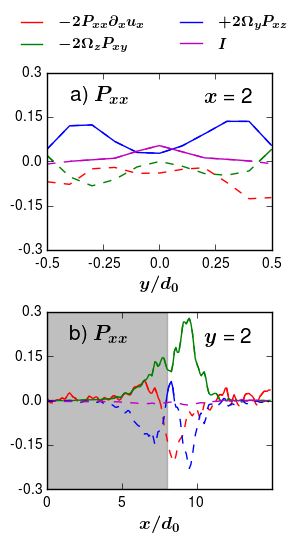

In [6]:
[DRIVER_COMP, DRIVER_ADV, DRIVER_SYM] = GetAvgDriver_ii(direct, times_avg)
CYCLOTRON_D = GetAvgCyclotron_ii(direct, times_avg)

i = 0 #Pxx
DATAS2PLOT = [DRIVER_SYM[i][0], CYCLOTRON_D[i][0], CYCLOTRON_D[i][1], IZO[i]]
LBL = ['$-2P_{xx}\partial_x u_x$' ,'$-2\Omega_zP_{xy}$','$+2\Omega_yP_{xz}$', '$I$']
presdiag = data[t][FIELD.PRESDIAG]

baseMask = presdiag[...,i]
major_ticks_y = np.arange(-0.3, 0.31, 0.15)
Y_LIM=[-0.3,0.3]
[axA, axB] = plotCrossSectionAlongYandAlongX(DATAS2PLOT, baseMask, xp, LBL, ['$P_{xx}$', '2'], Y_LIM, major_ticks_y)
LEGEND_FONTSIZE = 11
axA.legend(loc="upper left", bbox_to_anchor=[-0.2,1.4],
           ncol=2, shadow=False, fancybox=True, framealpha=0.0, fontsize=LEGEND_FONTSIZE)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.35)

filenew = fld+'pxx_.eps'
plt.savefig(filenew,dpi = 500, bbox_inches = "tight", format='eps') 

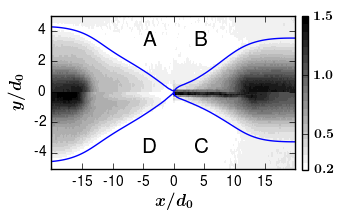

In [7]:
def getCombinedData(datas, fluxes):
    X_LENGTH = 200
    Y_LENGTH = 50
    DATA = np.zeros([2*X_LENGTH,2*Y_LENGTH])
    FLUX = np.zeros([2*X_LENGTH,2*Y_LENGTH])
    BOUND = [[[0,X_LENGTH,Y_LENGTH,2*Y_LENGTH], 
              [X_LENGTH,2*X_LENGTH,Y_LENGTH,2*Y_LENGTH]],
             [[0,X_LENGTH,0,Y_LENGTH],
              [X_LENGTH,2*X_LENGTH,0,Y_LENGTH]]]
    limits = [0,0,0,0]
    LMTS = [[[-1,1],[1,1]],[[-1,-1],[1,-1]]]
    for j in range(2):
        for i in range(2):
            data = datas[j][i]  
            flux = fluxes[j][i]
            xp = GetXPoint(flux)            
            middle_x = xp[0]
            middle_y = xp[1]
            limits[0] = middle_x
            limits[2] = middle_y
            FLUX0 = flux[middle_x,middle_y]
            if i == 0 and j==1:
                limits[2] = limits[2]+1
            if i == 1 and j==1:
                limits[0] = limits[0]
                limits[2] = limits[2]+1
            
            limits[1] = limits[0]+LMTS[j][i][0]*X_LENGTH
            limits[3] = limits[2]+LMTS[j][i][1]*Y_LENGTH
        
            if limits[3]<limits[2]:
                limits[3], limits[2] = limits[2], limits[3]
            if limits[1]<limits[0]:
                limits[1], limits[0] = limits[0], limits[1]
            DATA[BOUND[j][i][0]:BOUND[j][i][1], BOUND[j][i][2]:BOUND[j][i][3]] = data[limits[0]:limits[1],limits[2]:limits[3]]
            FLUX[BOUND[j][i][0]:BOUND[j][i][1], BOUND[j][i][2]:BOUND[j][i][3]] = flux[limits[0]:limits[1],limits[2]:limits[3]]-FLUX0
             
                
    return [DATA, FLUX]

def plotQuadrant(DATA, FLUX, vmin, vmax, cmap_ticks, cmap=cm.get_cmap('binary', 20) ):
    
    LABEL_FONTSIZE = 12
    TICKS_FONTSIZE = 10
    TEXT_FONTSIZE = 12
    NAME_TEXT_FONTSIZE = 15
    LEGEND_FONTSIZE = 15
    LINE_WIDTH = 1
    
    fig, ax2D = plt.subplots(nrows=1, ncols=1, figsize = cm2inch(8, 5), dpi = 300)
    
    labels = [ ['A', 'B'], ['D', 'C']]
    POS = [[[150,80],[235,80]],[[150,10], [235,10]]]
    for j in range(2):
        for i in range(2):
                ax2D.text(int(POS[j][i][0]),int(POS[j][i][1]), labels[j][i], color='black', 
                         bbox={'facecolor': 'none', 'pad': 5, 'edgecolor':'none'}, fontsize=NAME_TEXT_FONTSIZE)
   

    img = ax2D.imshow(np.transpose(DATA), interpolation = 'nearest',  origin='lower', 
                                    aspect = 'auto', vmin=vmin, vmax=vmax,  cmap=cmap)  

    ax2D.contour(np.transpose(FLUX),levels = [0.0], flines = None,colors = ('b',),origin = 'lower',
                                              linestyles = '-',linewidths = LINE_WIDTH)
    



    ax2D.set_xlabel(" $x/d_{0}$", fontsize=LABEL_FONTSIZE , weight='bold')
    ax2D.set_ylabel(" $y/d_{0}$", fontsize=LABEL_FONTSIZE , weight='bold')

    major_ticks_x = np.arange(50, 351, 50)
    major_ticks_y = np.arange(10, 91, 20)

    ax2D.set_xticks(major_ticks_x)
    ax2D.set_yticks(major_ticks_y)

    major_tickslab_x = np.arange(-15, 15.1, 5)
    major_tickslab_y = np.arange(-4, 4.1, 2)


    ax2D.set_xticklabels(major_tickslab_x.astype(int), fontsize=TICKS_FONTSIZE) 
    ax2D.set_yticklabels(major_tickslab_y.astype(int), fontsize=TICKS_FONTSIZE)  

    ax2D.tick_params(axis='x', which='major', pad=5)


    cbaxes = fig.add_axes([0.92, 0.12, 0.02, 0.78])
    cb = plt.colorbar(img, cax = cbaxes, ticks = cmap_ticks)
    cb.ax.tick_params(labelsize=TICKS_FONTSIZE)
    cbaxes.yaxis.set_ticks_position('right')

time =80.0
    
[dataIso, domainSize] = loadData([time], 'PATH_TO_RUN_B')
fluxIso = fourierFlux(dataIso[time][FIELD.MAGNETIC], domainSize)
[dataDemIso, domainSize] = loadData([time], 'PATH_TO_RUN_C')
fluxDemIso = fourierFlux(dataDemIso[time][FIELD.MAGNETIC], domainSize)
[dataNoIso, domainSize] = loadData([time], 'PATH_TO_RUN_D' )
fluxNoIso = fourierFlux(dataNoIso[time][FIELD.MAGNETIC], domainSize)
[dataNT, domainSize] = loadData([time], 'PATH_TO_RUN_A')

fluxNT = fourierFlux(dataNT[time][FIELD.MAGNETIC], domainSize)


fluxes = [[fluxNT, fluxIso],[ fluxNoIso, fluxDemIso]] 

datas = [[dataNT[time][FIELD.PRESDIAG][...,1], dataIso[time][FIELD.PRESDIAG][...,1]], 
         [ dataNoIso[time][FIELD.PRESDIAG][...,1], dataDemIso[time][FIELD.PRESDIAG][...,1]]]
    
vmin = 0.2 
vmax = 1.5
ticks=[0.2, 0.5, 1, 1.5]
    
[DATA, FLUX] = getCombinedData(datas, fluxes)
pyy0 = 0.375
DATA = DATA/pyy0


plotQuadrant(DATA, FLUX,vmin,vmax,ticks)

filenew = fld+'pyy_2d.eps'
plt.savefig(filenew,dpi = 500, bbox_inches = "tight",format='eps')

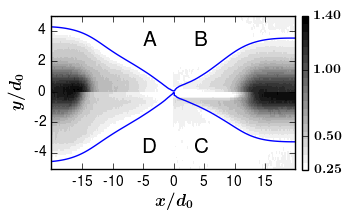

In [8]:
datas = [[dataNT[time][FIELD.DENSITYI][...,0], dataIso[time][FIELD.DENSITYI][...,0]], 
         [ dataNoIso[time][FIELD.DENSITYI][...,0], dataDemIso[time][FIELD.DENSITYI][...,0]]]
    
vmin = 0.25
vmax = 1.4
ticks=[0.25, 0.5, 1, 1.4]
    
[DATA, FLUX] = getCombinedData(datas, fluxes)
dens0 = 1.51
DATA = DATA/dens0


plotQuadrant(DATA, FLUX,vmin,vmax,ticks)

filenew = fld+'dens.eps'
plt.savefig(filenew,dpi = 500, bbox_inches = "tight",format='eps')

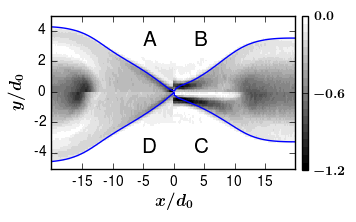

In [9]:
datas = [[dataNT[time][FIELD.CURRENTJ][...,2], dataIso[time][FIELD.CURRENTJ][...,2]], 
         [ dataNoIso[time][FIELD.CURRENTJ][...,2], dataDemIso[time][FIELD.CURRENTJ][...,2]]]
    
vmin = -1.2
vmax = 0.0
ticks=[-1.2, -0.6, 0.0]
    
[DATA, FLUX] = getCombinedData(datas, fluxes)
Jz0 = 1.0236
DATA = DATA/Jz0

cmap = cm.get_cmap('gray', 20)
plotQuadrant(DATA, FLUX,vmin,vmax,ticks,cmap)

filenew = fld+'jz.eps'
plt.savefig(filenew,dpi = 500, bbox_inches = "tight",format='eps')

In [41]:
def GetRecRate(fldr, maxTime, ts):
    frameNum  =int(maxTime/ts)
    recvel_ele_norm = np.zeros([frameNum])
    recvel_ele      = np.zeros([frameNum])
    coeffs      = np.zeros([frameNum-1])
    Az = np.zeros([frameNum])
    recvel_pot_norm = np.zeros([frameNum])
    recvel_pot = np.zeros([frameNum-1])
    upstream_pnt = 60
    downstream_pnt = 450
    av = 1
    for i in range(frameNum):
        time = ts*i
        [data, domainSize] = loadData([time], fldr)
        flux = fourierFlux(data[time][FIELD.MAGNETIC], domainSize)
        
        Xcoord = GetXPoint(flux)
            
        vcnt = (int(Xcoord[0]-av),int(Xcoord[0]+av),int(Xcoord[1]-av),int(Xcoord[1]+av))        
        vcnt_up =  (int(Xcoord[0]-av),int(Xcoord[0]+av),int(Xcoord[1]+upstream_pnt-av),int(Xcoord[1]+upstream_pnt+av))
        vcnt_down =  (int(Xcoord[0]+downstream_pnt-av),int(Xcoord[0]+downstream_pnt+av),int(Xcoord[1]-av),int(Xcoord[1]+av))
       
        Ne   = data[time][FIELD.DENSITYI][...,0]
        B    = data[time][FIELD.MAGNETIC]
        E    = data[time][FIELD.ELECTRIC]
        data.clear()
        Ne_up = np.mean(Ne[vcnt_up[0]:vcnt_up[1],vcnt_up[2]:vcnt_up[3]])        
        Bx_up = np.mean(B [vcnt_up[0]:vcnt_up[1],vcnt_up[2]:vcnt_up[3],0])
        By_up = np.mean(B [vcnt_up[0]:vcnt_up[1],vcnt_up[2]:vcnt_up[3],1])
        Bz_up = np.mean(B [vcnt_up[0]:vcnt_up[1],vcnt_up[2]:vcnt_up[3],2])
        Btot_up = np.sqrt(Bx_up*Bx_up + By_up*By_up + Bz_up*Bz_up)
        v_alf = Btot_up/np.sqrt(Ne_up)     
        try:
            recvel_ele[i] = -np.min(E[vcnt[0]:vcnt[1], vcnt[2]:vcnt[3],2])
            recvel_ele_norm[i] = recvel_ele[i]/(v_alf*Btot_up)
            Az_down = np.min(flux [vcnt_down[0]:vcnt_down[1],vcnt_down[2]:vcnt_down[3]])
            Az_0  = np.min(flux [vcnt[0]:vcnt[1], vcnt[2]:vcnt[3]])
            if i==0:
                delta = Az_0-Az_down
                Az[i] = 0
            else:
                Az[i] = Az_0-delta
            if i != 0:
                coeffs[i-1] = (v_alf*Btot_up)
        except ValueError:
            pass

    recvel_pot = -np.diff(Az)
    for i in range(1,frameNum):
        recvel_pot_norm[i] = recvel_pot[i-1]/coeffs[i-1]
    return [recvel_ele, recvel_ele_norm, recvel_pot, Az, recvel_pot_norm]


ts = 1.0
direct = 'PATH_TO_RUN_B' # iso   
[recvel_ele_iso, recvel_ele_norm_iso, recvel_pot_iso, Az_iso, Az_norm_iso] = GetRecRate(direct, 100.0, ts) 

direct = 'PATH_TO_RUN_C' # demiso
[recvel_ele_demiso, recvel_ele_norm_demiso, recvel_pot_demiso, Az_demiso, Az_norm_demiso] = GetRecRate(direct, 100.0, ts)  

direct = 'PATH_TO_RUN_D' # noiso   
[recvel_ele_noiso, recvel_ele_norm_noiso, recvel_pot_noiso, Az_noiso, Az_norm_noiso] = GetRecRate(direct, 100.0, ts) 

direct = 'PATH_TO_RUN_A' # nT
[recvel_ele_nT, recvel_ele_norm_nT, recvel_pot_nT, Az_nT, Az_norm_nT] = GetRecRate(direct, 100.0, ts) 

print recvel_ele_norm_nT[0]

0.00124911558941


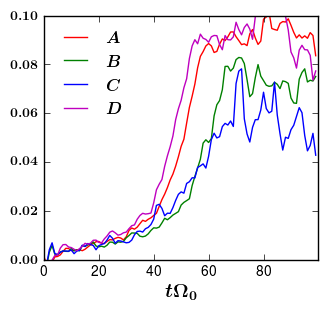

In [42]:
fig, ax = plt.subplots(num = 0, figsize = cm2inch(9, 8), dpi = 600)
from matplotlib.lines import Line2D

LABEL_FONTSIZE = 14
TICKS_FONTSIZE = 10
TEXT_FONTSIZE = 12
NAME_TEXT_FONTSIZE = 15
LEGEND_FONTSIZE = 12
LINE_WIDTH = 1


ax.set_xlabel('$t\Omega_0$ ', fontsize=LABEL_FONTSIZE , weight='bold')
ax.set_ylabel('')

LABELS = ['$A$','$B$','$C$','$D$']
SCALE = 5
LINESTYLES = ['-','-','-','-',]
CLRS = ['r','g','b','m',]

RATes = [recvel_ele_norm_nT,recvel_ele_norm_iso,recvel_ele_norm_demiso,recvel_ele_norm_noiso]

for i in range(len(RATes)):
    ratesm = sf(RATes[i], 5, 3)
    img = ax.plot(ratesm,color=CLRS[i],ls=LINESTYLES[i], label=LABELS[i] ,  lw=LINE_WIDTH)

ax.set_ylim([0.0,0.1])

Lx = len(RATes[0])
major_ticks_x = np.arange(0, Lx, Lx/5)
ax.set_xticks(major_ticks_x)
ax.set_xticklabels((major_ticks_x).astype(int), fontsize=LABEL_FONTSIZE , weight='bold')
ax.set_xlim([0.0,Lx])


major_ticks_y = np.arange(0.,0.11, 0.02)
ax.set_yticks(major_ticks_y)


plt.setp(ax.yaxis.get_majorticklabels(), fontsize=TICKS_FONTSIZE , weight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=TICKS_FONTSIZE , weight='bold')


custom_lines = [Line2D([0], [0], color='r', ls='-', lw=LINE_WIDTH),
                Line2D([0], [0], color='g', ls='-', lw=LINE_WIDTH),
                Line2D([0], [0], color='b', ls='-', lw=LINE_WIDTH),
                Line2D([0], [0], color='m', ls='-', lw=LINE_WIDTH)]
ax.legend(custom_lines, LABELS, loc="upper left", 
                        bbox_to_anchor=[0, 1], ncol=1, shadow=False, fancybox=True, framealpha=0.0, fontsize=LEGEND_FONTSIZE)


filenew = fld+'rec_rate.eps'
plt.savefig(filenew,dpi = 500, format='eps')


In [10]:
def getOhmsLawTerms4Ez(fldr, times):
    hyp = 0.001
    [data, domainSize] = loadData(times, fldr)
    Jz  = data[times[0]][FIELD.CURRENTJ][...,2]
    VixB =  np.zeros(Jz.shape)
    JxBn =  np.zeros(Jz.shape)
    hypresist =  np.zeros(Jz.shape)
    dPxzn =  np.zeros(Jz.shape)
    dPyzn =  np.zeros(Jz.shape)
    Ez  =  np.zeros(Jz.shape)
    NUM = len(times)
    for time in times:
        
        J  = data[time][FIELD.CURRENTJ]
        n  = data[time][FIELD.DENSITYI][...,0]
        Vi = data[time][FIELD.VELOCION]
        B  = data[time][FIELD.MAGNETIC]    
        Pxz = data[time][FIELD.PRESOFFD][...,1]
        Pyz = data[time][FIELD.PRESOFFD][...,2]
    
        VixB += -np.cross(Vi,B)[...,2]
        JxBn += np.cross(J,B)[...,2]/n
        hypresist +=  -hyp*(dx(dx(J[...,2]))+dy(dy(J[...,2])))
        dPxzn += -dx(Pxz)/n
        dPyzn += -dy(Pyz)/n
        
        Ez += data[time][FIELD.ELECTRIC][...,2]
        
    VixB /= NUM
    JxBn /= NUM
    hypresist /= NUM
    dPxzn /= NUM
    dPyzn /= NUM
    Ez /= NUM
    return [VixB, JxBn, hypresist, dPxzn, dPyzn, Ez]


[ 79.5  79.6  79.7  79.8  79.9  80.   80.1  80.2  80.3  80.4  80.5]


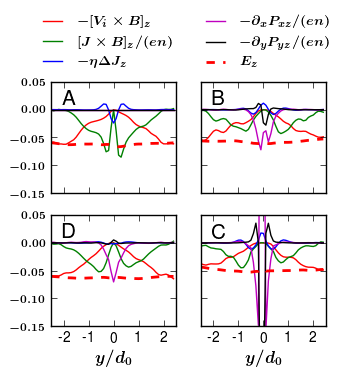

In [11]:
t =80.0
AVG_TIME = 0.5
times_avg = np.arange(t-AVG_TIME,t+AVG_TIME+0.1,0.1)
print times_avg

[dataIso, domainSize] = loadData([t], 'PATH_TO_RUN_B')
fluxIso = fourierFlux(dataIso[t][FIELD.MAGNETIC], domainSize)
[dataDemIso, domainSize] = loadData([t], 'PATH_TO_RUN_C')
fluxDemIso = fourierFlux(dataDemIso[t][FIELD.MAGNETIC], domainSize)
[dataNoIso, domainSize] = loadData([t], 'PATH_TO_RUN_D' )
fluxNoIso = fourierFlux(dataNoIso[t][FIELD.MAGNETIC], domainSize)
[dataNT, domainSize] = loadData([t], 'PATH_TO_RUN_A')
fluxNT = fourierFlux(dataNT[t][FIELD.MAGNETIC], domainSize)

FOLDERS = ['PATH_TO_RUN_A','PATH_TO_RUN_B','PATH_TO_RUN_C','PATH_TO_RUN_D']
datas = [dataNT, dataIso, dataDemIso, dataNoIso]
fluxes = [fluxNT,fluxIso,fluxDemIso,fluxNoIso]

labels = [ 'A', 'B', 'C', 'D']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = cm2inch(9, 8), dpi = 300)

LABEL_FONTSIZE = 12
LEGEND_FONTSIZE = 10
TICKS_FONTSIZE = 10
TEXT_FONTSIZE = 12
NAME_TEXT_FONTSIZE = 15
LINE_WIDTH = 1

limits = [0,0,0,0]
y_lim_1 = [-0.15,0.05]
labels = [ 'A', 'B', 'C', 'D']
EzMax = 0.15
major_ticks_y = np.arange(-2, 2.1, 1)

AX_NUM = [[0,0], [0,1], [1,1], [1,0]]
    
    
    
for j in range(4):
    
    [VixB, JxBn, hypresist, dPxzn, dPyzn, Ez] = getOhmsLawTerms4Ez(FOLDERS[j], times_avg)
    xp = GetXPoint(fluxes[j])
    middle_x = xp[0]
    middle_y = xp[1]
    
    limits[2] = xp[1]-25
    limits[3] = xp[1]+25
        
    axA = axes[AX_NUM[j][0]][AX_NUM[j][1]]
    axA.plot(VixB[middle_x,limits[2]:limits[3]],'r',label='$-[V_i \\times B]_z$', ls='-', lw=LINE_WIDTH)
    axA.plot(JxBn[middle_x,limits[2]:limits[3]],'g',label='$[J \\times B]_z/(en)$', ls='-', lw=LINE_WIDTH) 
    axA.plot(hypresist[middle_x,limits[2]:limits[3]],'b',label='$-\eta\Delta$$J_z$', ls='-', lw=LINE_WIDTH) 
    axA.plot(dPxzn[middle_x,limits[2]:limits[3]],'m',label='$-\partial_xP_{xz}/(en)$',  ls='-', lw=LINE_WIDTH) 
    axA.plot(dPyzn[middle_x,limits[2]:limits[3]],'k',label='$-\partial_yP_{yz}/(en)$',  ls='-', lw=LINE_WIDTH)
    
    axA.plot(Ez[middle_x,limits[2]:limits[3]],'r',label='$E_z$',  ls='--', lw=2*LINE_WIDTH)
    
    axA.set_xticks(np.arange(5, 46, 10))
    axA.set_xticklabels((major_ticks_y).astype(int))    
    axA.text(4.5, 0.01, labels[j], color='black', 
             bbox={'facecolor': 'none', 'pad': 5, 'edgecolor':'none'}, fontsize=NAME_TEXT_FONTSIZE)
    if  j == 0 or j ==1:
        axA.set_xticklabels('')
        
    if j == 1 or j == 2 : 
        axA.set_yticklabels('')
        
    plt.setp(axA.yaxis.get_majorticklabels(), fontsize=0.8*TICKS_FONTSIZE , weight='bold')    
    plt.setp(axA.xaxis.get_majorticklabels(), fontsize=TICKS_FONTSIZE , weight='bold')
    if  j == 3 or j ==2:
        axA.set_xlabel('$y / d_{0}$', fontsize=LABEL_FONTSIZE , weight='bold')    

    axA.set_ylim(y_lim_1)
    axA.set_xlim([0,50])
    if j == 0: 
        axA.legend(loc="lower left", bbox_to_anchor=[-0.2, 1.0],
               ncol=2, shadow=False, title="", fontsize=LEGEND_FONTSIZE, fancybox=True, framealpha=0.0)
   

filenew = fld+'ez_along_y.eps'
plt.savefig(filenew,dpi = 500, bbox_inches = "tight", format='eps') 

In [12]:
def getOhmsLawTerms4Ey(fldr, times):
    hyp = 0.001
    [data, domainSize] = loadData(times, fldr)
    Jy  = data[times[0]][FIELD.CURRENTJ][...,1]
    VixB =  np.zeros(Jy.shape)
    JxBn =  np.zeros(Jy.shape)
    hypresist =  np.zeros(Jy.shape)
    dPxyn =  np.zeros(Jy.shape)
    dPyyn =  np.zeros(Jy.shape)
    Ey  =  np.zeros(Jy.shape)
    NUM = len(times)
    for time in times:
        
        J  = data[time][FIELD.CURRENTJ]
        n  = data[time][FIELD.DENSITYI][...,0]
        Vi = data[time][FIELD.VELOCION]
        B  = data[time][FIELD.MAGNETIC]
        
        Pxy = data[time][FIELD.PRESOFFD][...,0]
        Pyy = data[time][FIELD.PRESDIAG][...,1]

        VixB += -np.cross(Vi,B)[...,1]
        JxBn += np.cross(J,B)[...,1]/n
        hypresist +=  -hyp*(dx(dx(J[...,1]))+dy(dy(J[...,1])))
        
        dPxyn += -dx(Pxy)/n
        dPyyn += -dy(Pyy)/n
        
        Ey += data[time][FIELD.ELECTRIC][...,1]
        
    VixB /= NUM
    JxBn /= NUM
    hypresist /= NUM
    dPxyn /= NUM
    dPyyn /= NUM
    Ey /= NUM
    return [VixB, JxBn, hypresist, dPxyn, dPyyn, Ey]



[ 79.5  79.6  79.7  79.8  79.9  80.   80.1  80.2  80.3  80.4  80.5]


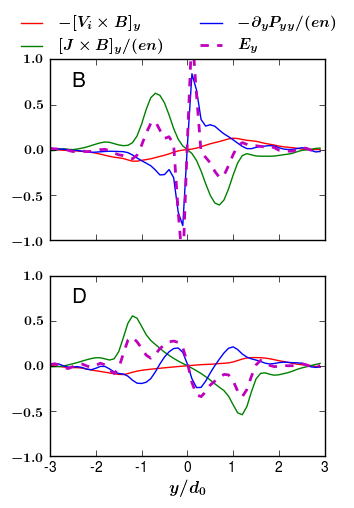

In [13]:
t =80.0
AVG_TIME = 0.5
times_avg = np.arange(t-AVG_TIME,t+AVG_TIME+0.1,0.1)
print times_avg

FOLDERS = ['PATH_TO_RUN_B', 'PATH_TO_RUN_D']

limits = [0,0,0,0]


LABEL_FONTSIZE = 12
LEGEND_FONTSIZE = 11
TICKS_FONTSIZE = 10
TEXT_FONTSIZE = 12
NAME_TEXT_FONTSIZE = 15
LINE_WIDTH = 1

y_lim_1 = [-1.0,1.0]   

deltaX = 0.1
deltaY = deltaX

fig, ax = plt.subplots(nrows=2, ncols=1, figsize = cm2inch(9, 13), dpi = 300)

for i in range(2):  
    [data, domainSize] = loadData([t], FOLDERS[i])
    flux = fourierFlux(data[t][FIELD.MAGNETIC], domainSize)
    xp = GetXPoint(flux)
    middle_x = xp[0]+40
    middle_y = xp[1]
    limits[2] = xp[1]-30
    limits[3] = limits[2]+60

    [VixB, JxBn, hypresist, dPxyn, dPyyn, Ey] = getOhmsLawTerms4Ey(FOLDERS[i], times_avg)

    axA = ax[i]
    
    axA.plot(VixB[middle_x,limits[2]:limits[3]],'r',label='$-[V_i \\times B]_y$', ls='-', lw=LINE_WIDTH)
    axA.plot(JxBn[middle_x,limits[2]:limits[3]],'g',label='$[J \\times B]_y/(en)$', ls='-', lw=LINE_WIDTH)
    axA.plot(dPyyn[middle_x,limits[2]:limits[3]],'b',label='$-\partial_yP_{yy}/(en)$',  ls='-', lw=LINE_WIDTH)
    axA.plot(Ey[middle_x,limits[2]:limits[3]],'m',label='$E_y$',  ls='--', lw=2*LINE_WIDTH)

    
    axA.set_xticks(np.arange(0, 61, 10))
    axA.set_xticklabels((np.arange(-3, 3.1, 1)).astype(int), fontsize=TICKS_FONTSIZE , weight='bold')
    if i == 0:
        axA.set_xticklabels("")

    fontsize = 25 
    if i == 1:
        axA.set_xlabel('$y / d_{0}$', fontsize=LABEL_FONTSIZE , weight='bold')    
    plt.setp(axA.yaxis.get_majorticklabels(), fontsize=TICKS_FONTSIZE , weight='bold')    
    plt.setp(axA.xaxis.get_majorticklabels(), fontsize=TICKS_FONTSIZE , weight='bold')
    axA.set_ylim(y_lim_1)
    axA.set_xlim([0,60])
    lbl = ['B', 'D']
    axA.text(5, y_lim_1[1]*0.7, lbl[i], fontsize=NAME_TEXT_FONTSIZE) 
    
ax[0].legend(loc="lower right", bbox_to_anchor=[1.1, 0.95],
               ncol=2, shadow=False, title="", fontsize=LEGEND_FONTSIZE, fancybox=True, framealpha=0.0)


filenew = fld+'ey_ohm.eps'
plt.savefig(filenew,dpi = 500, format='eps')

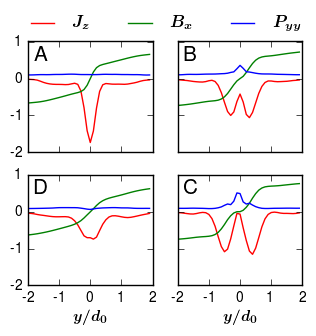

In [14]:
def getCurrentJzandBxzandTe(fldr, times):
    [data, domainSize] = loadData(times, fldr)
    Jz  = data[times[0]][FIELD.CURRENTJ][...,2]
    CURRENT  =  np.zeros(Jz.shape)
    BFIELD  =  np.zeros(Jz.shape)
    TEMP = np.zeros(Jz.shape)
    PRES = np.zeros(Jz.shape)
    NUM = len(times)
    for time in times:        
        BFIELD += data[time][FIELD.MAGNETIC][...,0]
        CURRENT += data[time][FIELD.CURRENTJ][...,2]
        pres = data[time][FIELD.PRESDIAG]
        dens = data[time][FIELD.DENSITYI][...,0]
        PRES = data[time][FIELD.PRESDIAG][...,1]
        TEMP += (pres[...,0]+pres[...,1]+pres[...,2])/3/dens
        
    CURRENT /= NUM
    BFIELD /= NUM
    TEMP /= NUM
    return [CURRENT, BFIELD, PRES, TEMP]



FLDR = ['PATH_TO_RUN_A', 'PATH_TO_RUN_B', 'PATH_TO_RUN_C', 'PATH_TO_RUN_D']
LABELS = ['A','B','C','D']

time = 68.0
AVG_TIME = 0.2
times_avg = np.arange(time-AVG_TIME,time+AVG_TIME+0.1,0.1)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = cm2inch(9, 8), dpi = 300)


LABEL_FONTSIZE = 11
LEGEND_FONTSIZE = 12
TICKS_FONTSIZE = 10
TEXT_FONTSIZE = 12
NAME_TEXT_FONTSIZE = 15
LINE_WIDTH = 1


AX_NUM = [[0,0], [0,1], [1,1], [1,0]]

for i in range(4):
    [data, domainSize] = loadData([time], FLDR[i])
    flux = fourierFlux(data[time][FIELD.MAGNETIC], domainSize)
    xp = GetXPoint(flux)
    middle_x = xp[0]  
    middle_y = xp[1]
    yl = middle_y-20
    yr = middle_y+20
    ax = axes[AX_NUM[i][0]][AX_NUM[i][1]]
    [CURRENT, BFIELD, PRES, TEMP] = getCurrentJzandBxzandTe( FLDR[i], times_avg)

    ax.plot(CURRENT[middle_x,yl:yr],label='$J_z$', color='r', ls='-', lw=LINE_WIDTH)
    ax.plot(BFIELD[middle_x,yl:yr],label='$B_x$', color='g', ls='-', lw=LINE_WIDTH)
    ax.plot(PRES[middle_x,yl:yr],label='$P_{yy}$', color='b', ls='-', lw=LINE_WIDTH)

    xsize = yr - yl
    ax.set_xlim([0,xsize])
    major_ticks_x = np.arange(0, xsize+1, xsize/4)
    label_ticks_x = np.arange(-xsize/2, xsize, xsize/4)*0.1    
    ax.set_xticks(major_ticks_x)
    ax.set_xticklabels('')
    if i == 2 or i == 3: 
        ax.set_xticklabels((label_ticks_x).astype(int), fontsize=LABEL_FONTSIZE , weight='bold')
        
        
    ax.text(2, 0.5, LABELS[i], color='black', bbox={'facecolor': 'none', 'pad': 5, 'edgecolor':'none'}, fontsize=NAME_TEXT_FONTSIZE)


    Max_v = 1.0

    Min_v = -2.
    sizey = Max_v-Min_v
    ax.set_ylim([Min_v,Max_v+0.01])
    major_ticks_y = np.arange(Min_v, Max_v+0.01, sizey/3)
    label_ticks_y = np.arange(Min_v, Max_v+0.01, sizey/3)
    ax.set_yticks(major_ticks_y)
    ax.set_yticklabels('')
    if i == 0 or i == 3 : 
        ax.set_yticklabels(label_ticks_y.astype(int))
   
    if i == 2 or i == 3 :         
        ax.set_xlabel('$y / d_{0}$', fontsize=LABEL_FONTSIZE , weight='bold')
        ax.set_ylabel('', fontsize=LABEL_FONTSIZE , weight='bold')

    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=TICKS_FONTSIZE , weight='bold')
    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=TICKS_FONTSIZE , weight='bold')
    if i == 1: 
        ax.legend(loc="lower right", bbox_to_anchor=[1.1, 0.95],
           ncol=3, shadow=False, title="",framealpha=0.0, fancybox=False, fontsize = LEGEND_FONTSIZE)
        
        
filenew = fld+'jz_lineout.eps'
plt.savefig(filenew,dpi = 500, format='eps')